# Brief description of how to use petitRADTRANS for different cloud composition and spectra up to 15 μm

*Jorge Anais Vilchez  
14 August 2020*

In this tutorial I will show you how to use petitRADTRANS to perform a spectra model, in particular the case with spectra covering from 0.3 μm to 15 μm, and using different cloud composition. For further info check the official documentation https://petitradtrans.readthedocs.io/en/latest/index.html. All the units are in cgs except for pressure which is in units of bar.

I am assuming that you have already installed petitRADTRANS (instructions of how to install in https://petitradtrans.readthedocs.io/en/latest/content/installation.html) and you have downloaded all the necessary data files.

## Preparing a radiative transfer object

To start, we first load petitRADTRANS module and some utilities

In [1]:
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc
import numpy as np

The most relevant class in petitRADTRANS is `Radtrans`. To instanciate a Radtrans object you need to specify all **opacity species** that you want to use to perform the models, including:

 - Atomic line absorbers (high and low resolution)
 - Rayleigh scatterers
 - Continuum opacity sources
 - Cloud opacities

You can find a complete list of the species availables at https://petitradtrans.readthedocs.io/en/latest/content/available_opacities.html
 
There are two **resolution modes**:
 
 - `'c-k'`: correlated-k mode (low resolution)
 - `'lbl'`: The line by line mode (high resolution)
 
Also you have to provide the **wavelenght range** in microns. Instantiation of this object could take a while ($\lesssim 1$ min), mainly because it has to load the corresponding opacities for each specie from their respectives files.



In [2]:
atmosphere = Radtrans(line_species=['C2H2', 'CH4', 'CO', 'CO2', 'H2', 'H2O', 'H2S', 'HCN', 'NH3', 'OH', 'PH3', 'VO'],
                      rayleigh_species=['H2', 'He'],
                      continuum_opacities=['H2-H2', 'H2-He'],
                      cloud_species=['Mg2SiO4(c)_cd'],
                      wlen_bords_micron = [0.3, 15],
                      mode='c-k')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



### Pressure
Then, the pressures of the atmospheric layers must be defined. Pressures must always be sorted in increasing order, and be equidistant in log-space. They recommend to use ~100 layers. We also set $P_0=0.01$ bar

In [3]:
pressure = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressure)

p0 = 0.01  # bar

## Calculating a transmission spectrum



### Surface Gravity
In this example I will use the warm giant planet **HD1397b**, their physical parameters are

$M_{p} = 0.367 M_J$  
$R_{p} = 1.023 R_J$

First we calculate the surface gravity

In [4]:
m_pl = 0.367 * nc.m_jup
r_pl = 1.023 * nc.r_jup

gravity = nc.G * m_pl / r_pl ** 2

### Temperature 

To calculate the transmission spectrum we need to provide a temperature model for each layer, It could be a simple isothermal model or something like [Guillot](https://ui.adsabs.harvard.edu/abs/2010A%26A...520A..27G/abstract) (2010), that we are going to use now. We assume an atmosphere equilibrium temperature of 500 K.

In [5]:
kappa_IR = 0.01
gamma = 0.4
T_int = 200
T_equ = 500

temperature = nc.guillot_global(pressure, kappa_IR, gamma, gravity, T_int, T_equ)

### Abundances and Mean molecular weight

Then we have to provide an abundance dictionary, containing the **mass fraction** of the atmospheric material, at every layer, and the atmospheric mean molecular weight, at every layer, in units of amu.

To do that we are going to use the values obtaind by `easy_chem` fortran code. This code allows to calculate the mass fractions of the reactants at certain pressure and temperature given the numeric fraction of the available atoms. What this code does is to minimize the total Gibbs free energy of all possible species while conserving the number of atoms of every atomic species.

Note: To compile your own version of `easy_chem` you need a fortran compiler (in my case I have installed gfortran 9.3.0). Just execute `make clean` and then `make` and it should generate some files including `call_easy_chem` executable.

I tried with different atomic fractions, as detailed in the following table:

|          | Solar         | Subsolar      | Earth-like    | 10x solar     | 10x less solar |
|----------|---------------|---------------|---------------|---------------|----------------|
| H nfrac  | 0.92075393050 | 0.74353810000 | 0.00000056000 | 0.91347838014 |  0.92148148562 |
| He nfrac | 0.07836886940 | 0.24100303000 | 0.00000524000 | 0.07774961963 |  0.07843079438 |
| C nfrac  | 0.00024782410 | 0.00228489000 | 0.00037900000 | 0.00247824100 |  0.00002478241 |
| N nfrac  | 0.00006225061 | 0.00057122000 | 0.78084000000 | 0.00062250606 |  0.00000622506 |
| O nfrac  | 0.00045096580 | 0.01002145000 | 0.20946000000 | 0.00450965800 |  0.00004509658 |
| Na nfrac | 0.00000160009 | 0.00003556000 | 0.00012831604 | 0.00001600087 |  0.00000016001 |
| Mg nfrac | 0.00003665587 | 0.00081457000 | 0.00293955071 | 0.00036655874 |  0.00000366559 |
| Al nfrac | 0.00000259500 | 0.00005767000 | 0.00020810127 | 0.00002595000 |  0.00000025950 |
| Si nfrac | 0.00002979500 | 0.00066211000 | 0.00238935547 | 0.00029795000 |  0.00000297950 |
| P nfrac  | 0.00000023667 | 0.00000526000 | 0.00001897933 | 0.00000236670 |  0.00000002367 |
| S nfrac  | 0.00001213790 | 0.00026973000 | 0.00097337672 | 0.00012137901 |  0.00000121379 |
| Cl nfrac | 0.00000029117 | 0.00000647000 | 0.00002334968 | 0.00000291168 |  0.00000002912 |
| K nfrac  | 0.00000009866 | 0.00000219000 | 0.00000791190 | 0.00000098661 |  0.00000000987 |
| Ca nfrac | 0.00000201439 | 0.00004476000 | 0.00016154033 | 0.00002014390 |  0.00000020144 |
| Ti nfrac | 0.00000008206 | 0.00000182000 | 0.00000658083 | 0.00000082062 |  0.00000000821 |
| V nfrac  | 0.00000000784 | 0.00000017000 | 0.00000062846 | 0.00000007837 |  0.00000000078 |
| Fe nfrac | 0.00002911680 | 0.00064704000 | 0.00233496813 | 0.00029116796 |  0.00000291168 |
| Ni nfrac | 0.00000152807 | 0.00003396000 | 0.00012254087 | 0.00001528071 |  0.00000015281 |
| TOTAL    | 0.99999999992 | 1.00000000000 |    1.00000000 | 1.00000000000 |  1.00000000000 |
| C/O      |          0.55 |          0.23 |          0.00 |          0.55 |           0.55 |
| C/N      |          3.98 |          4.00 |          0.00 |          3.98 |           3.98 |
| [Fe/H]   |          0.00 |          1.44 |          8.12 |          1.00 |          -1.00 |
 

Solar composition is extracted from Asplund et al. (2009). Other columns are custom made.
For each column here, I create a `*.inp` file with their respective values. You can find this files in the folder `easy_chem/`. 


The program will read by default `abundances.inp`, so you will have to rename the apropiate inp file.

**Important**: Make sure that all the species that you want to consider are included in the list of reactants in the file `abundances.inp`.

To call `easy_chem` I use an intermediary function in python `get_PT_abundances_MMW` (see teh attached file `utils.py`). This function will return a dictionary with the reactant mass fractions and the mean molecular weight.





In [6]:
from utils import read_abunds, get_PT_abundances_MMW

abundances, mmw = get_PT_abundances_MMW(pressure, temperature)

## Setting the cloud particle size

We have to define a few additional parameters for the clouds: the mean particle size and width of the log-normal particle distribution.

Note: in this case we are only considering one condensate, if you want to add more make sure to add them to the .ino file and define the corresponding mean particle size like below.

In [7]:
radius = {}
radius['Mg2SiO4(c)'] = 0.00005 * np.ones_like(temperature) # I.e. a 0.5-micron particle size (0.00005 cm)

sigma_lnorm = 1.05

## Running the model

Finally, we can perform the calculation

In [8]:
atmosphere.calc_transm(temperature,
                       abundances,
                       gravity,
                       mmw,
                       R_pl=r_pl,
                       P0_bar=p0,
                       radius=radius,
                       sigma_lnorm=sigma_lnorm)

Now we plot the results

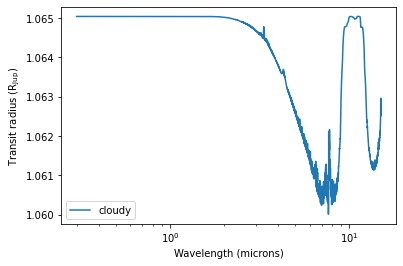

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.transm_rad/nc.r_jup_mean, label = 'cloudy')
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc='best')
plt.show()
plt.clf()